# langgraph-engineer

As discussed in the [doc](https://www.notion.so/LangGraph-Engineer-06e5e2e15b014995b698b3cb00da053c), we want to build LangGraphs from:

1. A user image
2. User Q+A interaction

`Here is the overall flow`

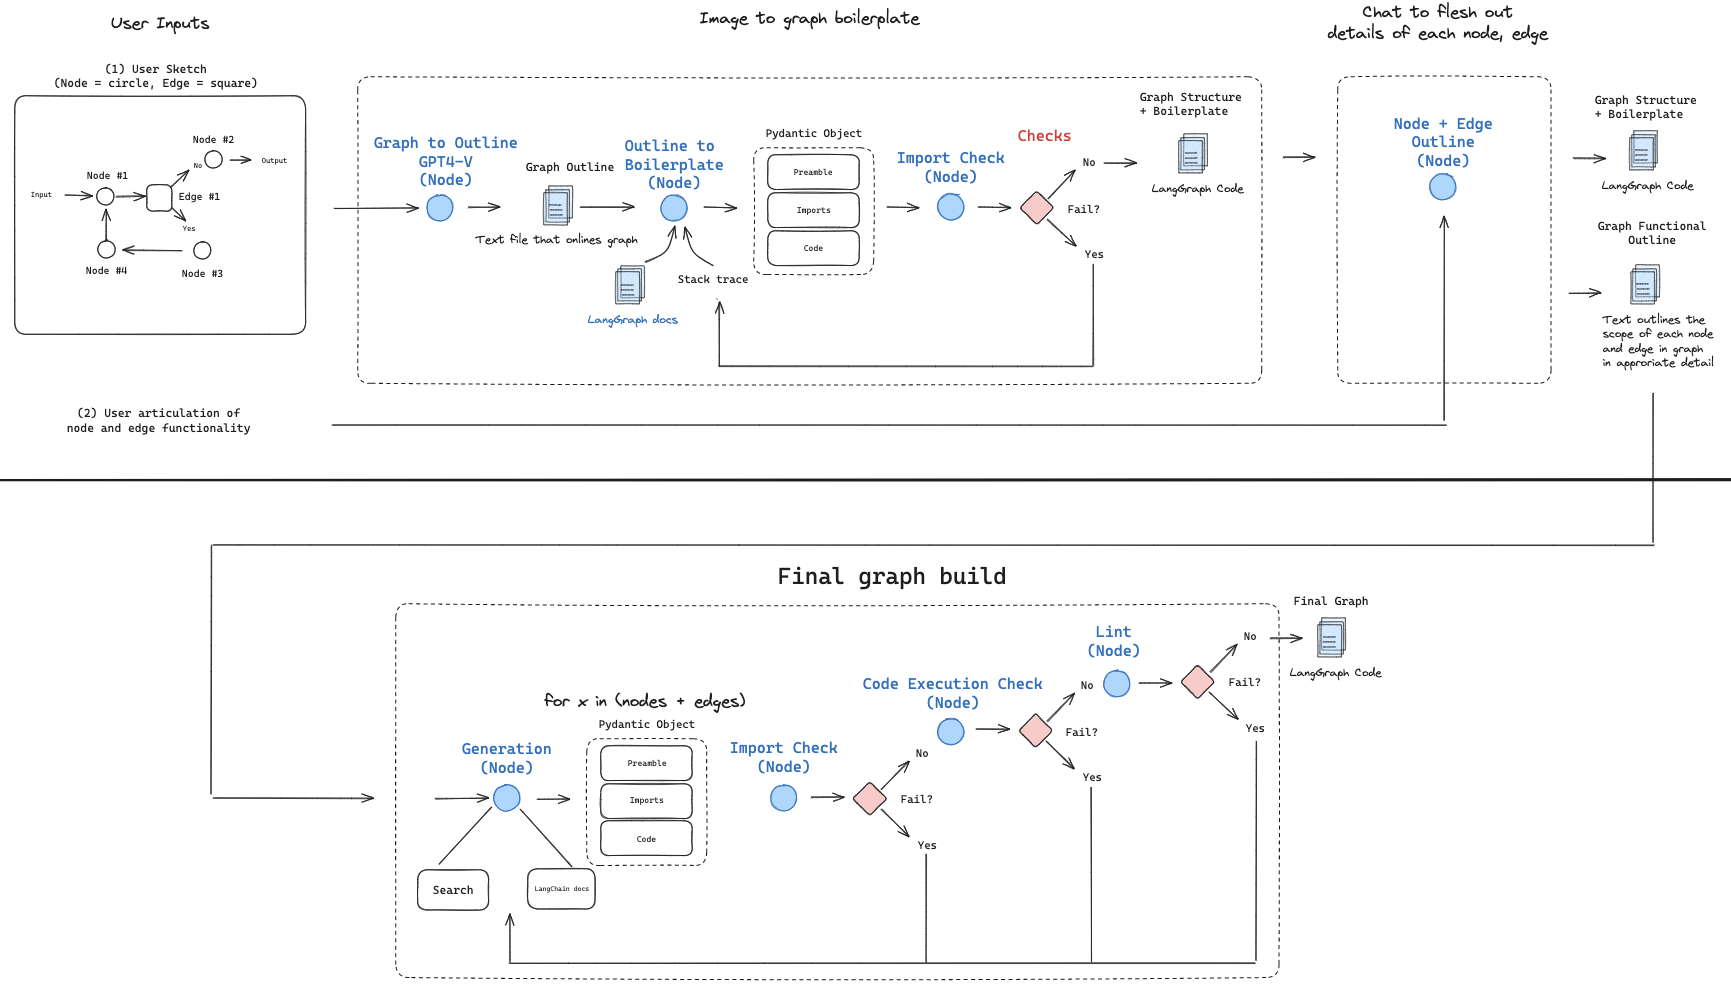


# Image to graph boilerplate

### LangGraph docs

In [3]:
# %pip install -U langgraph bs4 langchain_community

In [4]:
## Docs

from bs4 import BeautifulSoup as Soup
from langchain_community.document_loaders.recursive_url_loader import RecursiveUrlLoader

# LangGraph docs 
url = "https://python.langchain.com/docs/langgraph/"
loader = RecursiveUrlLoader(
    url=url, max_depth=20, extractor=lambda x: Soup(x, "html.parser").text
)
docs = loader.load()

# Sort the list based on the URLs in 'metadata' -> 'source'
d_sorted = sorted(docs, key=lambda x: x.metadata["source"])
d_reversed = list(reversed(d_sorted))

# Concatenate the 'page_content'
langgraph_docs = "\n\n\n --- \n\n\n".join(
    [doc.page_content for doc in d_reversed]
)

### User image

In [2]:
import base64
import os
def encode_image(image_path):
    """Getting the base64 string"""
    with open(image_path, "rb") as image_file:
        return base64.b64encode(image_file.read()).decode("utf-8")

image_path = "CRAG.jpg"
img_base_64 = encode_image(image_path)

### Image-to-code

In [3]:
from langchain_core.pydantic_v1 import BaseModel, Field
from langchain_core.utils.function_calling import convert_to_openai_tool
from langchain_core.prompts import ChatPromptTemplate 
from langchain.output_parsers.openai_tools import PydanticToolsParser
from langchain_openai import ChatOpenAI

# Image to LangGraph boilerplate prompt
template="""Here are the full LangGrah docs: \n --- --- --- \n {docs} \n --- --- --- \n 
            You will be shown an image of a graph with nodes as circles and edges \n
            as squares. Each node and edge has a label. Use the provided LangGraph docs to convert \n
            the image into a LangGraph graph. This will have 3 things: (1) create a dummy \n
            state value. (2) Define a dummy function for each each node or edge. (3) finally \n
            create the graph workflow that connects all edges and nodes together. \n
            Structure your answer with a description of the code solution. \n
            Then list the imports. And finally list the functioning code block.""" 

prompt = ChatPromptTemplate.from_messages(
        [("system", "You are an expert in converting graph visualizations into LangGrah."),
         ("human",[
             {"type": "text", "text": template},
             {"type": "image_url","image_url": "data:image/jpeg;base64,{my_image}"}
                ],
         ),
        ]
    ) 

# Multi-modal LLM
model = ChatOpenAI(temperature=0, model="gpt-4-vision-preview", max_tokens="1028")

chain = (
    prompt
    | model 
)

code_solution = chain.invoke({"my_image": img_base_64, "docs": langgraph_docs})

### Code-to-structured output

In [4]:
from langchain_core.pydantic_v1 import BaseModel, Field
from langchain.output_parsers.openai_tools import PydanticToolsParser
from langchain_core.utils.function_calling import convert_to_openai_tool

# Structured output prompt
template="""You are an expert a code formatting, strating with a code solution \n
            \n --- --- \n {code} \n --- --- \n Structure the solution in three parts \n
            with a prefix that defines the problem, then list the imports, and finally \n
            list the functioning code block.""" 

prompt = ChatPromptTemplate.from_messages(
        [("system", "You are an expert at code formatting."),
         ("human",[
             {"type": "text", "text": template},
                ],
         ),
        ]
    ) 

# Data model
class code(BaseModel):
    """Code output"""
    prefix: str = Field(description="Description of the problem and approach")
    imports: str = Field(description="Code block import statements")
    code: str = Field(description="Code block not including import statements")

# LLM
model = ChatOpenAI(temperature=0, model="gpt-4-0125-preview")

# Tool
code_tool_oai = convert_to_openai_tool(code)

# LLM with tool and enforce invocation
llm_with_tool = model.bind(
    tools=[code_tool_oai],
    tool_choice={"type": "function", "function": {"name": "code"}},
)

# Parser
parser_tool = PydanticToolsParser(tools=[code])

chain = (
    prompt
    | llm_with_tool 
    | parser_tool
)

formatted_code = chain.invoke({"code": code_solution})

Here is te resulting code - 

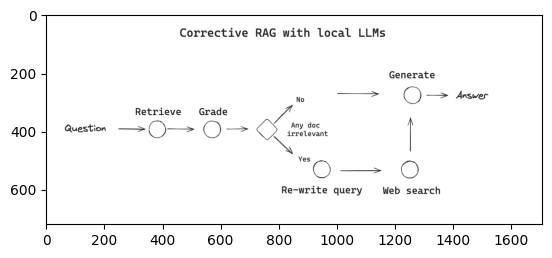

In [8]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
img = mpimg.imread('CRAG.jpg')
plt.imshow(img)

In [11]:
exec(formatted_code[0].imports)

In [12]:
exec(formatted_code[0].code)

{'question': 'Rewritten question', 'documents': ['doc1', 'doc2', 'doc1', 'doc2', 'web_doc1'], 'answer': 'Generated answer'}


In [10]:
### From the imports, code from above ###

from typing import TypedDict, Annotated, List
from langgraph.graph import StateGraph
import operator

from typing import TypedDict, List, Annotated
import operator

# Define the state of the graph
class AgentState(TypedDict):
    question: str
    documents: Annotated[List[str], operator.add]
    answer: str

# Dummy functions for each node
def retrieve(state: AgentState):
    # Dummy retrieval logic
    return {"documents": ["doc1", "doc2"]}

def grade(state: AgentState):
    # Dummy grading logic
    return state

def generate(state: AgentState):
    # Dummy generation logic
    return {"answer": "Generated answer"}

def rewrite_query(state: AgentState):
    # Dummy query rewriting logic
    return {"question": "Rewritten question"}

def web_search(state: AgentState):
    # Dummy web search logic
    return {"documents": ["web_doc1"]}

# Dummy function for the conditional edge
def is_doc_relevant(state: AgentState):
    # Dummy relevance checking logic
    return "yes" if "relevant_doc" in state["documents"] else "no"

# Assuming a class StateGraph is defined elsewhere that handles the workflow logic
# Create the graph workflow
workflow = StateGraph(AgentState)

# Add nodes to the graph
workflow.add_node("retrieve", retrieve)
workflow.add_node("grade", grade)
workflow.add_node("generate", generate)
workflow.add_node("rewrite_query", rewrite_query)
workflow.add_node("web_search", web_search)

# Set the entry point
workflow.set_entry_point("retrieve")

# Add edges to the graph
workflow.add_edge("retrieve", "grade")
workflow.add_conditional_edges(
    "grade",
    is_doc_relevant,
    {
        "yes": "generate",
        "no": "rewrite_query"
    }
)
workflow.add_edge("rewrite_query", "web_search")
workflow.add_edge("web_search", "generate")

# Set the finish point
workflow.set_finish_point("generate")

# Compile the graph into a runnable application
app = workflow.compile()

# Example usage
inputs = {"question": "What is the weather like today?"}
output = app.invoke(inputs)
print(output)

{'question': 'Rewritten question', 'documents': ['doc1', 'doc2', 'doc1', 'doc2', 'web_doc1'], 'answer': 'Generated answer'}


# Chat + Graph Build

`Open question`

*  Perform all the user-guided QA prior to graph up front (like GPT-Engineer).

or 

* Build each node / edge individually with user-guided QA per-node / edge.